## Ejercicio 3

### En este caso el ejercicio es bastante complejo de lograr visualizar pues unicamente se gira la muñeca/mano levemente de su posición inicial.

In [9]:
import json
import numpy as np
import os

def load_landmark_data(file_path):

    if not os.path.isfile(file_path):
        raise ValueError(f"La ruta {file_path} no es un archivo válido.")


    with open(file_path, "r") as f:
        data = json.load(f)

    X, y = [], []

    max_landmarks = 0

    for video_name, frames in data.items():
        for frame_data in frames:
            landmarks = []


            pose = frame_data.get("pose", {})
            hands = frame_data.get("hands", [])


            for key in ["left_arm", "right_arm"]:
                if key in pose:
                    for coords in pose[key]:
                        landmarks.extend(coords)


            for hand_points in hands:
                for coords in hand_points:
                    landmarks.extend(coords)


            max_landmarks = max(max_landmarks, len(landmarks))


            X.append(landmarks)
            y.append(frame_data["label"])


    for i in range(len(X)):
        while len(X[i]) < max_landmarks:
            X[i].append(0.0)

    return np.array(X), np.array(y)


file_path = "/content/drive/MyDrive/pract3Landmrks/labelsejer3.json"


X, y = load_landmark_data(file_path)
X = X / np.max(X)

print(f"Datos cargados: {X.shape}, Etiquetas: {len(y)}")


Datos cargados: (7632, 144), Etiquetas: 7632


### En este caso se tenian varios lanmarks faltantes en nuestros datos, para normalizar esto se completo con ceros

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de entrenamiento:", X_train.shape, "Tamaño de prueba:", X_test.shape)


Tamaño de entrenamiento: (6105, 144) Tamaño de prueba: (1527, 144)


## Entrenamiento SVM

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


model = SVC(kernel="linear")
model.fit(X_train, y_train_encoded)

print("Modelo entrenado")


Modelo entrenado


In [13]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")


print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


Precisión del modelo: 0.5455
              precision    recall  f1-score   support

        full       0.93      0.34      0.49       573
        none       0.41      0.89      0.56       411
     partial       0.63      0.50      0.56       543

    accuracy                           0.55      1527
   macro avg       0.66      0.58      0.54      1527
weighted avg       0.68      0.55      0.54      1527



In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Entrenamiento con MLP classifier

Se obtiene un excelente resultado

In [17]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
model_mlp.fit(X_train_scaled, y_train_encoded)

y_pred_mlp = model_mlp.predict(X_test_scaled)
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        full       0.99      0.99      0.99       573
        none       1.00      0.99      0.99       411
     partial       0.99      0.99      0.99       543

    accuracy                           0.99      1527
   macro avg       0.99      0.99      0.99      1527
weighted avg       0.99      0.99      0.99      1527



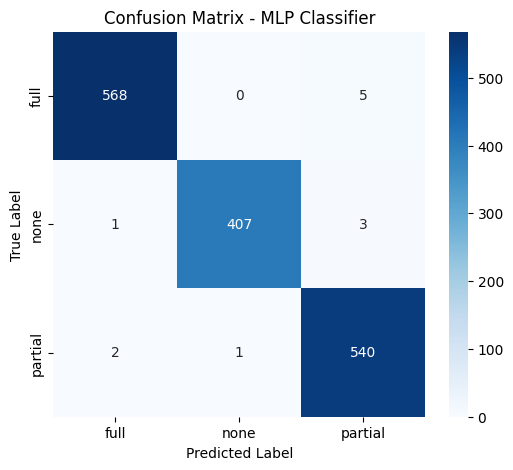

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred_mlp)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MLP Classifier")
plt.show()


## Comparativa de ambos modelos

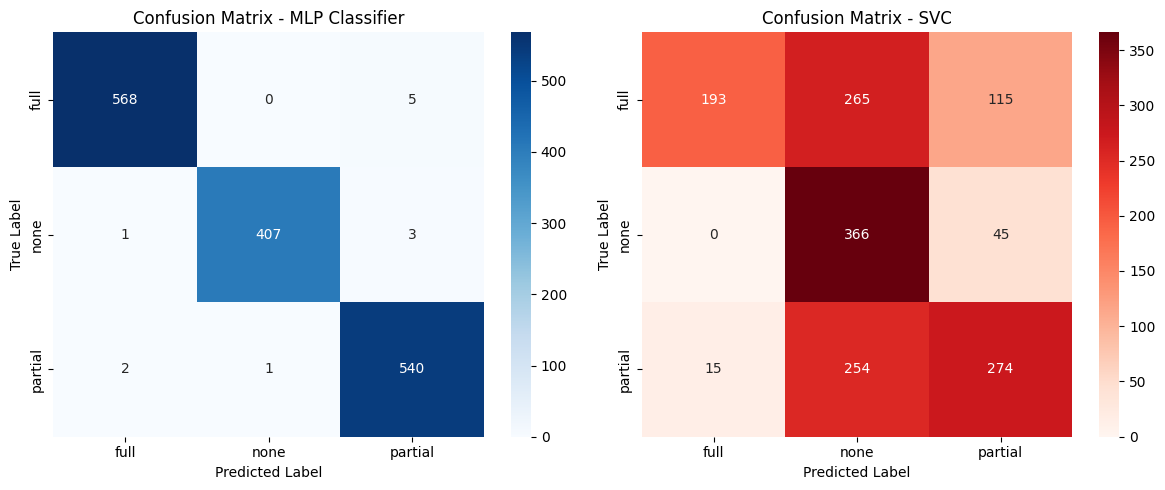

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_mlp = confusion_matrix(y_test_encoded, y_pred_mlp)
cm_svc = confusion_matrix(y_test_encoded, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix - MLP Classifier")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_svc, annot=True, fmt="d", cmap="Reds", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix - SVC")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


# Evaluación Externa

In [26]:
import cv2
import mediapipe as mp
import numpy as np
import json

mp_holistic = mp.solutions.holistic

def extract_landmarks_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    holistic = mp_holistic.Holistic(static_image_mode=False)

    landmarks_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        landmarks = []


        if results.pose_landmarks:
            pose_landmarks = results.pose_landmarks.landmark
            left_arm_indices = [11, 13, 15]
            right_arm_indices = [12, 14, 16]

            for index in left_arm_indices + right_arm_indices:
                landmarks.extend([pose_landmarks[index].x, pose_landmarks[index].y, pose_landmarks[index].z])


        if results.left_hand_landmarks:
            landmarks.extend([lm.x for lm in results.left_hand_landmarks.landmark])
            landmarks.extend([lm.y for lm in results.left_hand_landmarks.landmark])
            landmarks.extend([lm.z for lm in results.left_hand_landmarks.landmark])

        if results.right_hand_landmarks:
            landmarks.extend([lm.x for lm in results.right_hand_landmarks.landmark])
            landmarks.extend([lm.y for lm in results.right_hand_landmarks.landmark])
            landmarks.extend([lm.z for lm in results.right_hand_landmarks.landmark])

        landmarks_list.append(landmarks)

    cap.release()
    holistic.close()


    max_landmarks = 144
    for i in range(len(landmarks_list)):
        while len(landmarks_list[i]) < max_landmarks:
            landmarks_list[i].append(0.0)

    return np.array(landmarks_list)

video_path = "/content/drive/MyDrive/pract3vids/test.mp4"
X_new = extract_landmarks_from_video(video_path)

In [27]:
from sklearn.preprocessing import StandardScaler

X_new_scaled = scaler.transform(X_new)

In [28]:

y_pred_new = model_mlp.predict(X_new_scaled)


from collections import Counter
most_common_label = Counter(y_pred_new).most_common(1)[0][0]

predicted_class = label_encoder.inverse_transform([most_common_label])[0]

print(f"El modelo predice que el ejercicio realizado en el video es: {predicted_class}")

El modelo predice que el ejercicio realizado en el video es: partial


## Muestra de landmarks en video de prueba

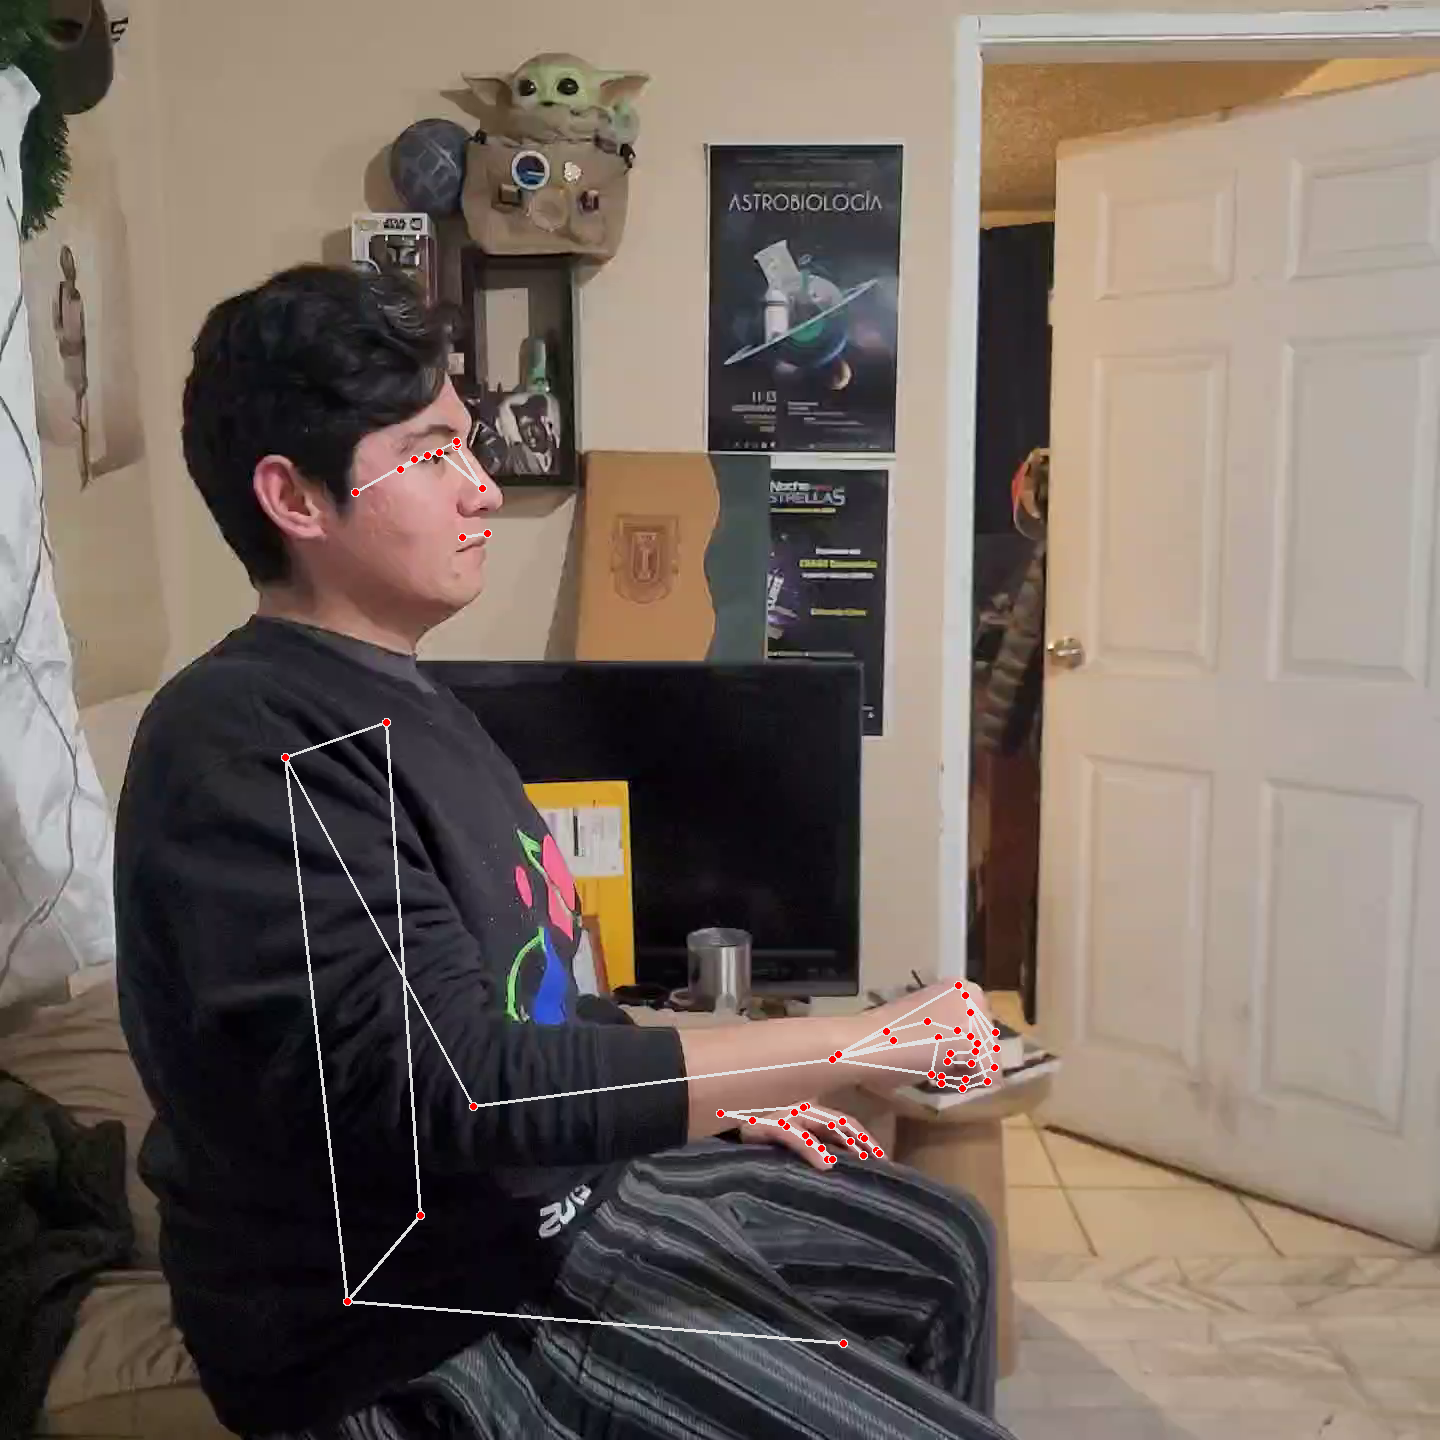

In [30]:
import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

video_path = "/content/drive/MyDrive/pract3vids/test.mp4"
cap = cv2.VideoCapture(video_path)

with mp_holistic.Holistic(static_image_mode=False) as holistic:
    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)


        mp_drawing.draw_landmarks(
            frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(
            frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(
            frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)


        cv2_imshow(frame)


cap.release()